In [ ]:
!pip install mesa numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
import mesa
print("mesa loaded from:", mesa.__file__)

mesa loaded from: /usr/local/lib/python3.11/dist-packages/mesa/__init__.py


In [ ]:
print(mesa.__version__)

3.1.5


## ESERCIZIO 1
# How can we parameterize our model to replicate the results shown in figures 1b and 1d of Hauert and Doebeli (2004)?

**1) Obiettivo dell'esercizio**

L'obiettivo è replicare i risultati delle Figure 1b e 1d dell'articolo di Hauert & Doebeli (2004), che analizzano l'evoluzione della cooperazione nel gioco della neve (snowdrift game) in una popolazione distribuita su una griglia. Si osserva come varia la frequenza dei cooperatori al variare del rapporto costo/beneficio (r), confrontando due dinamiche (aggiornamento sincrono e asincrono) e due tipi di vicinato: N=4 (Von Neumann) e N=8 (Moore).

**Snowdrift game**

Il gioco della neve modella una situazione in cui la cooperazione è utile, ma faticosa, e dove è meglio che qualcuno cooperi, piuttosto che nessuno.

A differenza del dilemma del prigioniero, qui non è sempre conveniente defezionare: chi coopera da solo ottiene comunque un piccolo vantaggio.

La dinamica è questa:

- Se entrambi cooperano, si dividono lo sforzo e guadagnano bene.

- Se uno solo coopera, l’altro lo sfrutta e guadagna di più.

- Se nessuno coopera, entrambi restano bloccati e non ottengono nulla.

**Nel gioco della neve non esiste una strategia dominante**: la miglior scelta dipende da cosa fa l’altro. Questo **rende possibile la coesistenza tra cooperazione e defezione all’interno della popolazione.**

**2) Il codice**

Gli agenti sono posizionati su una griglia toroidale e interagiscono con i loro vicini locali, decidendo a ogni turno se mantenere o cambiare strategia. Ogni agente può cooperare (strategia 0) o defezionare (strategia 1), e il proprio guadagno viene calcolato in base alla strategia propria e di ciascun vicino, usando una matrice di payoff calcolata dinamicamente in base al parametro r (rapporto costo/beneficio della cooperazione).

Viene definita la classe dell’agente.
 L’agente identifica i propri vicini, gioca il gioco con ciascuno di loro, calcola il proprio guadagno, decide se cambiare strategia confrontandosi con un vicino e infine aggiorna il proprio stato.

Viene definito il modello globale, che costruisce la griglia, assegna le strategie iniziali (50% cooperazione, 50% defezione) e gestisce l’aggiornamento degli agenti, sia in modo sincrono che asincrono. La matrice dei payoff ha la forma [[R, S], [T, P]]:

  R = b - c/2 (entrambi cooperano),

  S = b - c (tu coopera, l’altro no),

  T = b (tu defezioni, l’altro coopera),

   P = 0 (entrambi defezionano).
   
   Il beneficio b è fissato a 1 e il costo c viene ricavato da r.
   
Si esegue la simulazione per vari valori di r da 0 a 1, misurando la frequenza finale di cooperazione per entrambe le modalità di aggiornamento (sincrono e asincrono), e ripetendo più volte l’esperimento per avere medie stabili. Nel quarto blocco si genera il grafico finale, che riporta su un asse i valori di r e sull’altro la frequenza di cooperatori a fine simulazione. Le due figure prodotte (panel b e panel d) rappresentano rispettivamente il caso con 4 vicini (N=4) e con 8 vicini (N=8).
















Panel b (N=4):


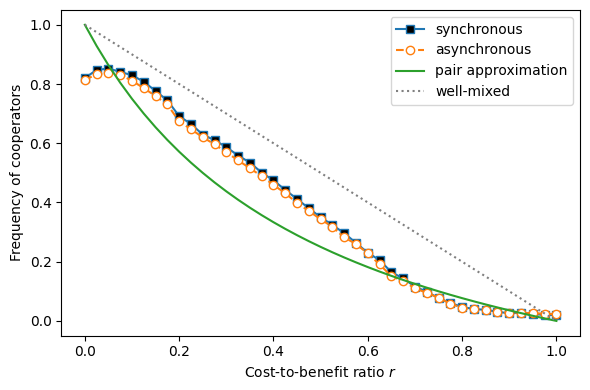

Panel d (N=8):


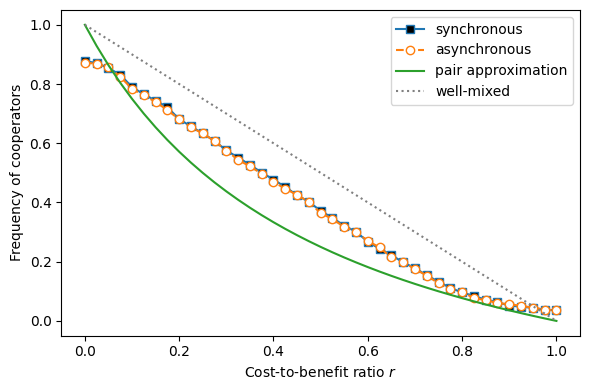

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import random
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.space import MultiGrid

# ---------------- Agent Definition ----------------
#definito il singolo agent
class PatchAgent(Agent):
    """
    Agent representing a single individual in the snowdrift game.
    """
    def __init__(self, model, unique_id, pos):
        super().__init__(model)
        self.unique_id = unique_id
        self.pos = pos
        self.strategy = None
        self.strategy_after = None
        self.payoff = 0

    def compute_neighbors(self):
        # calcolo del vicinato (moore=False,N=4) or Moore (moore=True,N=8)
        self.neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=self.model.moore,
            include_center=False,
            radius=1
        )

    def play(self):
        # ogni agente gioca con l'altro; per ogni vicino: consulta la matrice payoff, somma i risultati delle interazioni e ottiene payoff totale
        self.compute_neighbors()
        total = 0.0
        for nbr in self.neighbors:
            total += self.model.payoff_matrix[self.strategy][nbr.strategy]
        self.payoff = total

    def revise(self):
        # aggiornamento della strategia:  con probabilità noise cambia strategia a caso (mutazione)
        if random.random() < self.model.noise:
            # mutation
            self.strategy_after = random.choice([0, 1])
            return
        if not self.neighbors:  # se non ha vicini, mantiene la sua strategia
            self.strategy_after = self.strategy
            return              #sceglie un vicino casualmente, calcola la differenza di payoff
        opp = random.choice(self.neighbors)
        delta = opp.payoff - self.payoff
        # imita la strategia del vicino con probabilità proporzionale al vantaggio
        prob = max(0, delta / self.model.max_diff / len(self.neighbors))
        self.strategy_after = opp.strategy if random.random() < prob else self.strategy

    def step(self):
        # interaction phase
        self.play()

    def advance(self):
        # strategy update phase
        self.revise()
        self.strategy = self.strategy_after

# ---------------- Model Definition ----------------
#creato ambiente, tipo d'aggiornamento e tipo vicinato
class GameModel(Model):
    def __init__(
        self,
        width,
        height,
        payoff_matrix,
        init_dist,
        noise=0.01,
        synchronous=True,
        moore=False
    ):
    #  viene salvata la matrice dei payoff usata per calcolare il guadagno di ogni agente in base alla propria strategia e a quella dei vicini
    # si calcola il massimo possibile scarto di payoff tra due agenti:
    # questo valore viene poi usato per calcolare la probabilità con cui un agente decide di cambiare strategia in base alla differenza di payoff rispetto a un vicino.
    #  Si memorizzano le due impostazioni fondamentali del modello:
    #   → self.synchronous: indica se gli agenti si aggiornano tutti insieme (sincrono) o uno alla volta (asincrono).
    #   → self.moore : tipo di vicinato
    #imposta il livello di rumore (randomness): una piccola probabilità con cui un agente cambia strategia a caso, invece di seguire la regola razionale
        super().__init__()
        self.grid = MultiGrid(width, height, torus=True)
        # payoff_matrix: [[R, S], [T, P]]
        self.payoff_matrix = payoff_matrix
        flat = [p for row in payoff_matrix for p in row]
        self.max_diff = max(flat) - min(flat)
        self.noise = noise
        self.synchronous = synchronous
        self.moore = moore

        # creata la griglia con un agente per cella
        self.patch_agents = []
        uid = 0
        for x in range(width):
            for y in range(height):
                a = PatchAgent(self, uid, (x, y))
                self.grid.place_agent(a, (x, y))
                self.patch_agents.append(a)
                uid += 1
        # distribuzione delle strategie iniziali, metà 0 e metà 1
        half = width * height // 2
        choices = [0]*half + [1]*(width*height - half)
        random.shuffle(choices)
        for a, s in zip(self.patch_agents, choices):
            a.strategy = s
            a.strategy_after = s

    def step(self):
        if self.synchronous:
            # allora tutti prima giocano poi aggiornano la strategia
            for a in self.patch_agents:
                a.step()

            for a in self.patch_agents:
                a.advance()
        else:
            # altrimenti ogni agente gioca e poi aggiorna immediatamente la strategia uno alla volta
            random.shuffle(self.patch_agents)
            for a in self.patch_agents:
                a.step()
                a.advance()

# ---------------- Run Panel b (N=4 von Neumann) ----------------


def run_panel_b(
    width=50,
    height=50,
    noise=0.01,
    steps=500,
    runs=5
):
    return run_panel(width, height, noise, steps, runs, moore=False)

# ---------------- Run Panel d (N=8 Moore) ----------------
def run_panel_d(
    width=50,
    height=50,
    noise=0.01,
    steps=500,
    runs=5
):
    return run_panel(width, height, noise, steps, runs, moore=True)

# ---------------- Generic panel function ----------------
#creato un ciclo di 41 valori di r (da 0 a 1)
#per ciascun valore viene calcolato il costo c a partire da r

def run_panel(
    width,
    height,
    noise,
    steps,
    runs,
    moore
):
    r_vals = np.linspace(0, 1, 41)
    sync_freq = []
    async_freq = []

    for r in r_vals:
        # convert r = c/(2b - c) to c with b=1
        c = 2 * r / (1 + r)
        b = 1.0
        # definita la matrice payoff: R=b - c/2, S=b - c; T=b, P=0
        payoff_matrix = [
            [b - c/2, b - c],
            [b,       0   ]
        ]
        dist = [width*height//2, width*height - width*height//2]

        #vengono salvate le frequenze finali dei cooperatori sia per aggiornamento sincrono che asincrono

        # synchronous updating
        vals = []
        for _ in range(runs):
            m = GameModel(width, height, payoff_matrix, dist,
                          noise=noise, synchronous=True, moore=moore)
            for _ in range(steps): m.step()
            vals.append(sum(a.strategy==0 for a in m.patch_agents)/(width*height))
        sync_freq.append(np.mean(vals))

        # asynchronous updating
        vals = []
        for _ in range(runs):
            m = GameModel(width, height, payoff_matrix, dist,
                          noise=noise, synchronous=False, moore=moore)
            for _ in range(steps): m.step()
            vals.append(sum(a.strategy==0 for a in m.patch_agents)/(width*height))
        async_freq.append(np.mean(vals))

    # pair approximation
    def pair_approx(r): return (1 - r)/(1 + 2*r)
    pa_vals = [pair_approx(r) for r in r_vals]

    # plot
    plt.figure(figsize=(6, 4))
    plt.plot(r_vals, sync_freq, 's-',  label='synchronous', markerfacecolor='black')
    plt.plot(r_vals, async_freq,'o--', label='asynchronous', markerfacecolor='white')
    plt.plot(r_vals, pa_vals, '-',    label='pair approximation')
    plt.plot(r_vals, 1 - r_vals, ':', color='gray', label='well-mixed')
    plt.xlabel('Cost-to-benefit ratio $r$')
    plt.ylabel('Frequency of cooperators')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------- Main ----------------
if __name__ == "__main__":
    print("Panel b (N=4):")
    run_panel_b()
    print("Panel d (N=8):")
    run_panel_d()


# **I grafici**

Le due figure mostrano come cambia la frequenza dei cooperatori al variare del rapporto costo/beneficio
𝑟
, in due diversi contesti:
Panel b (N=4) e Panel d (N=8).

Ogni curva rappresenta una modalità di aggiornamento: sincrono (tutti insieme) o asincrono (uno alla volta).

**Nel Panel b (N=4), la curva sincrona è leggermente più alta di quella asincrona: questo significa che aggiornare tutti insieme aiuta a mantenere la cooperazione**.

 **In Panel d (N=8), le due curve sono quasi sovrapposte: avere più vicini rende i cooperatori più vulnerabili, e la cooperazione crolla più facilmente.**

In entrambi i casi, le curve simulazione (sincrono e asincrono) stanno sotto la curva tratteggiata grigia (well-mixed), cioè il caso teorico in cui tutti interagiscono con tutti.
Questo mostra che, **nel gioco della neve, la struttura spaziale ostacola la cooperazione**, al contrario di quanto accade in altri giochi come il dilemma del prigioniero.

Infine, **la cooperazione diminuisce all’aumentare di
𝑟 ** : più costa cooperare, meno agenti scelgono di farlo. Confrontando le due figure, si vede che **N=4 è più favorevole alla cooperazione rispetto a N=8, perché avere meno vicini aiuta i cooperatori a formare piccoli gruppi che si difendono dai defezionatori.**

